In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
import scipy.special as sc
from scipy.integrate import odeint
import process_utility as psu
import scipy.integrate as integ
from scipy.optimize import curve_fit
import time
import math
import os

In [2]:
def process_abalone_data(filename,nn=1000,nplot=5,width_calc=False):
    #fvolt=(filename.split('/')[-1].split('.')[0].split('_')[5])
    #fled=(filename.split('/')[-1].split('.')[0].split('_')[8])
    #sipmn=(filename.split('/')[-1].split('.')[0].split('_')[4])
    #sipmv=(filename.split('/')[-1].split('.')[0].split('_')[5])
    #print(f'ABALONE at {fvolt}V {sipmn} at {sipmv} with {fled}')
    #print(f'ABALONE at {fvolt}V')
    
    samples = 1024
    data = np.fromfile(filename,  dtype=np.int16)
    n = len(data)/samples
    print(filename,'Number of events',n)
    data = np.array(np.array_split(np.array(data),n))
    
    MINs, FOMs, MAXs, INTs, width50, ENTRs, RTs = [], [], [], [], [], [], []
    ts = time.time()
    plt.figure(figsize=(12,6))
    if nn == 0: nn = len(data)
    for i in range(nn):
        if (i % 50000) == 0: print(f'event n. {i} time to process: {time.time()-ts:.2f}')
        #bl = np.max(data[i][:])
        bl = np.mean(data[i][:40])
        wf = bl-data[i]
        ll, hh = int(len(wf)/2)-200, int(len(wf)/2)+200
        max_pos = np.where(wf == np.max(wf[ll:hh]))[0][0]
        area = np.sum(wf[max_pos-10:max_pos+90])
        if area > 1: fom = np.sum(wf[max_pos:max_pos+90])/area
        else: fom = 0
        MINs.append(bl)
        MAXs.append(np.max(wf))
        FOMs.append(fom)
        INTs.append(area)
        #fwhm = np.where(wf>np.max(wf)*0.5)[0][-1]-np.where(wf>np.max(wf)*0.5)[0][0]
        #FWHMs.append(fwhm)
        if np.sum(wf) > 1:
            norm = np.abs(wf[wf!=0])/np.sum(wf)
            entropy = -np.sum(norm*np.log10(norm))
        else: entropy = 0
        
        ENTRs.append(entropy)
        try:
            t10 = np.where(wf[ll:hh]>=np.max(wf[ll:hh])*0.1)[0][0]
            t90 = np.where(wf[ll:hh]>=np.max(wf[ll:hh])*0.9)[0][0]
            risetime = t90-t10
        except:
            risetime = 0
        RTs.append(risetime)
        if width_calc:
            ii, areafrac = 1, 0
            while areafrac < 0.5:
                ilo50, ihi50 = max_pos-ii, max_pos+ii
                areafrac = np.sum(wf[ilo50:ihi50])/area
                ii += 1
                wid50 = ihi50 - ilo50
            width50.append(wid50)
            if i < nplot: plt.plot(wf,label=f'A={area:.1f}, width={wid50:.1f}')
        else:
            if i < nplot: plt.plot(wf,label=f'A={area:.1f}, entropy={entropy:.2f}, rt={risetime:.2f}')
    plt.legend()
    data = pd.DataFrame(columns=['area','width','peak_max','baselines','fom','entropy','risetime'])
    data['area'] = INTs
    if width_calc: data['width'] = width50
    data['peak_max'] = MAXs
    data['baselines'] = MINs
    data['fom'] = FOMs
    data['entropy'] = ENTRs
    data['risetime'] = RTs
    d_out = './processed_data'
    try: os.mkdir(d_out)
    except: pass
    #data.to_hdf(f'{d_out}/ABALONE_{fvolt}V_{sipmn}_{sipmv}_{fled}.h5', key='df', mode='w')
    data.to_hdf(f'{d_out}/ABALONE_18kV_NoLED_20211907.h5', key='df', mode='w')
    return data

/home/valerio/Scaricati/2021_07_19_T0940_18kV_100threshold.dat Number of events 229945.0
event n. 0 time to process: 0.03
event n. 50000 time to process: 5.72
event n. 100000 time to process: 11.18
event n. 150000 time to process: 17.07
event n. 200000 time to process: 22.77


/home/valerio/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block2_values] [items->Index(['width'], dtype='object')]

  encoding=encoding,


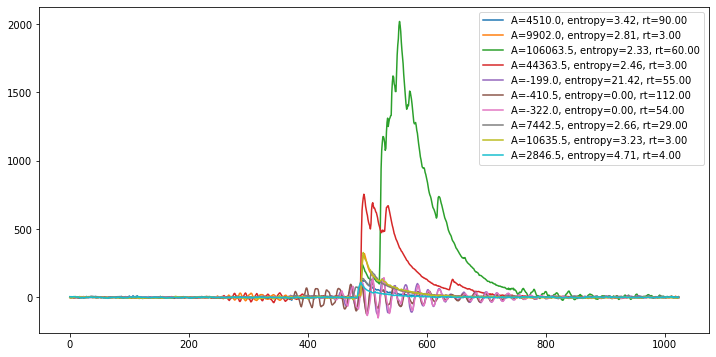

In [3]:
data = process_abalone_data(filename='/home/valerio/Scaricati/2021_07_19_T0940_18kV_100threshold.dat',nn=0,nplot=10)

In [3]:
def plot_area_spectrum(AREAs,bins=200,low=3.5, high=6):
    area_space = np.logspace(low,high, bins)
    plt.figure(figsize=(12,6))
    a=plt.hist(AREAs,bins=area_space,histtype='step',lw=2)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('area')
    plt.xlabel('ADC channels',ha='right',x=1)
    plt.ylabel('counts',ha='right',y=1)

In [4]:
def plot_area_max(AREAs,MAXs,bins=200,volts=10,low=3.5, high=6,low2=0.5, high2=4.5):
    area_space = np.logspace(low,high, bins)
    max_space = np.logspace(low2,high2,bins)
    plt.figure(figsize=(12,6))
    a=plt.hist2d(AREAs,MAXs,bins=(area_space,max_space),norm=matplotlib.colors.LogNorm())
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('area (chn)',ha='right',x=1,fontsize=12)
    plt.ylabel('peak max (chn)',ha='right',y=1,fontsize=12)
    plt.title(f'ABALONE at {volts} kV')
    
def plot_area_fom(AREAs,FOMs,bins=200,volts=10,low=3.5, high=6):
    area_space = np.logspace(low,high, bins)
    plt.figure(figsize=(12,6))
    a=plt.hist2d(AREAs,FOMs,bins=(area_space,bins),norm=matplotlib.colors.LogNorm())
    plt.xscale('log')
    plt.xlabel('area',ha='right',x=1,fontsize=12)
    plt.ylabel('FOM',ha='right',y=1,fontsize=12)
    plt.title(f'ABALONE at {volts} kV')
    
def plot_area_width(AREAs,width50,bins=200,volts=10,low=3.5, high=6,low2=1.5, high2=4.5):
    area_space = np.logspace(low,high, bins)
    width_space = np.logspace(low2,high2, bins)
    plt.figure(figsize=(12,6))
    a=plt.hist2d(AREAs,width50,bins=(area_space,width_space),norm=matplotlib.colors.LogNorm())
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('area',ha='right',x=1,fontsize=12)
    plt.ylabel('width 50%',ha='right',y=1,fontsize=12)
    plt.title(f'ABALONE at {volts} kV')
    
def plot_area_entropy(AREAs,ENTRs,bins=200,volts=10,low=3.5, high=6,low2=2, high2=3.1):
    area_space = np.logspace(low, high, bins)
    entr_space = np.linspace(low2,high2, bins)
    plt.figure(figsize=(12,6))
    a=plt.hist2d(AREAs,ENTRs,bins=(area_space,entr_space),norm=matplotlib.colors.LogNorm())
    plt.xscale('log')
    plt.xlabel('area',ha='right',x=1,fontsize=12)
    plt.ylabel('entropy',ha='right',y=1,fontsize=12)
    plt.title(f'ABALONE at {volts} kV')
    
def plot_area_risetime(AREAs,RTs,bins=200,volts=10,low=3.5, high=6,low2=0, high2=3.5):
    area_space = np.logspace(low, high, bins)
    rt_space = np.logspace(low2,high2, bins)
    plt.figure(figsize=(12,6))
    a = plt.hist2d(AREAs,RTs,bins=(area_space,rt_space),norm=matplotlib.colors.LogNorm())
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('area',ha='right',x=1,fontsize=12)
    plt.ylabel('risetime (ns)',ha='right',y=1,fontsize=12)
    plt.title(f'ABALONE at {volts} kV')

def plot_risetime_entropy(RTs,ENTRs,bins=200,volts=10,low=0, high=3.5,low2=2, high2=3.1):
    rt_space = np.logspace(low,high, bins)
    entr_space = np.linspace(low2,high2, bins)
    plt.figure(figsize=(12,6))
    a = plt.hist2d(RTs,ENTRs,bins=(rt_space,entr_space),norm=matplotlib.colors.LogNorm())
    plt.xscale('log')
    plt.xlabel('risetime (ns)',ha='right',x=1,fontsize=12)
    plt.ylabel('entropy',ha='right',y=1,fontsize=12)
    plt.title(f'ABALONE at {volts} kV')

In [5]:
def plot_data(data,fvolt=16,low=3.5, high=6,low2=1.5, high2=4.5,low3=2, high3=3.1):
    #data = pd.read_hdf(f'processed_data/ABALONE_{fvolt}kV_SiPM{sipmn}_{sipmv}V_{fled}.h5')
    plot_area_spectrum(data['area'],low=low,high=high)
    plot_area_max(data['area'],data['peak_max'],bins=200,volts=fvolt,low=low,high=high)
    plot_area_fom(data['area'],data['fom'],bins=200,volts=fvolt,low=low,high=high)
    plot_area_entropy(data['area'],data['entropy'],bins=200,volts=fvolt,low=low,high=high,low2=low3,high2=high3)
    plot_area_risetime(data['area'],data['risetime'],bins=200,volts=fvolt,low=low,high=high)
    plot_risetime_entropy(data['risetime'],data['entropy'],bins=200,volts=fvolt,low2=low3,high2=high3)
    #plot_area_width(INTs,FWHMs,bins=200,volts=volts)

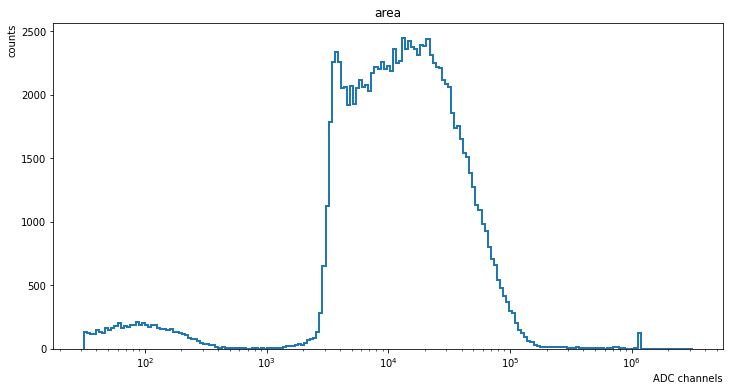

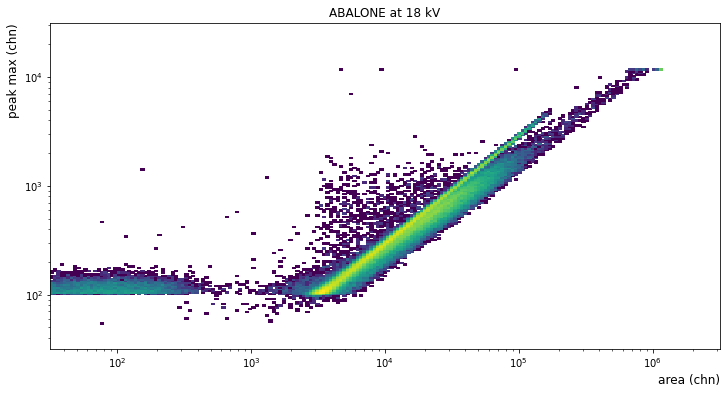

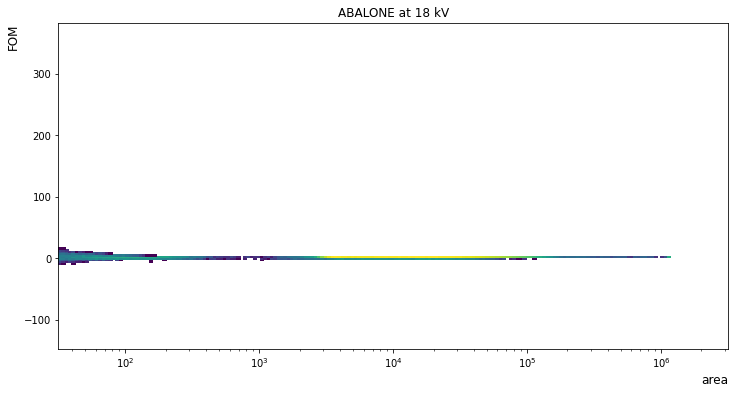

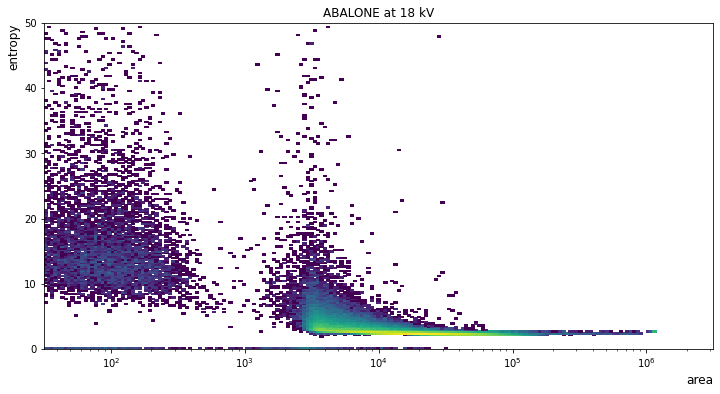

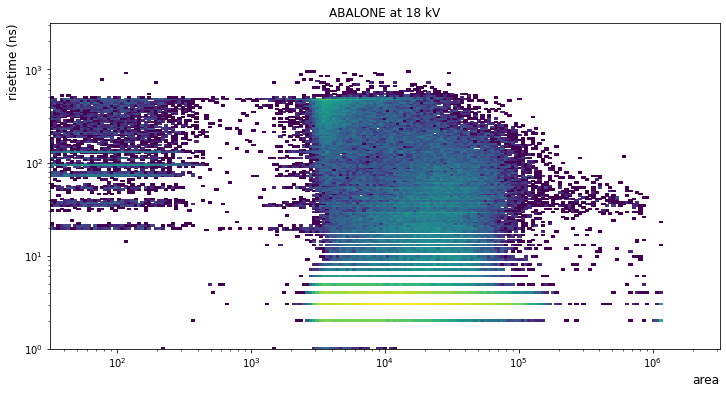

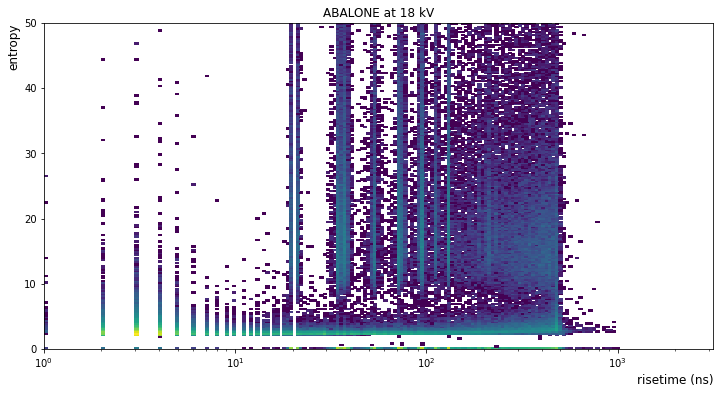

In [26]:
data = pd.read_hdf('processed_data/ABALONE_18kV_NoLED_20211907.h5')
plot_data(data=data,fvolt=18,low=1.5, high=6.5,low3=0, high3=50)

In [12]:
def select_data(data,filename,fvolt=18,entr_cut=20,max_cut=20,area_cut=1,rt_cut=100,events=10):
    wfs = psu.read_file(filename)
    # cut on area
    wfs_cut_area = wfs[(data['area']<area_cut)]
    try: psu.plot_waveforms( wfs_cut_area, events = events )
    except: pass
    print('Events rejected by area ',len(wfs_cut_area),'->',len(wfs_cut_area)/len(data)*100,'%')
    # cut on entropy
    wfs_cut_entr = wfs[(data['entropy']>entr_cut)]
    psu.plot_waveforms( wfs_cut_entr, events = events )
    print('Events rejected by entropy ',len(wfs_cut_entr),'->',len(wfs_cut_entr)/len(data)*100,'%')
    # cut on max
    wfs_cut_max = wfs[data['peak_max']<max_cut]
    try: psu.plot_waveforms( wfs_cut_max, events = events )
    except: pass
    print('Events rejected by max ',len(wfs_cut_max),'->',len(wfs_cut_max)/len(data)*100,'%')
    # cut on risetime
    wfs_cut_rt = wfs[data['risetime']<rt_cut]
    try: psu.plot_waveforms( wfs_cut_rt, events = events )
    except: pass
    print('Events rejected by risetime ',len(wfs_cut_rt),'->',len(wfs_cut_rt)/len(data)*100,'%')
    # selection
    mask = (data['entropy']>0) & (data['entropy']<entr_cut) & (data['peak_max']>max_cut) & (data['area']>area_cut) & (data['risetime']>rt_cut)
    wfs_sel = wfs[mask]
    data_sel = data[mask]
    psu.plot_waveforms( wfs_sel, events = events )
    plot_data(data=data_sel,fvolt=fvolt,low=1.5, high=6.5,low3=1, high3=5)
    print('Events selected ',len(data_sel),'->',len(data_sel)/len(data)*100,'%')
    return data_sel, wfs_sel

/home/valerio/Scaricati/2021_07_19_T0940_18kV_100threshold.dat Number of events 229945.0
Events rejected by entropy  66635 -> 28.978668812107244 %
Events rejected by max  219 -> 0.09524016612668247 %
Events selected  108880 -> 47.350453369283954 %


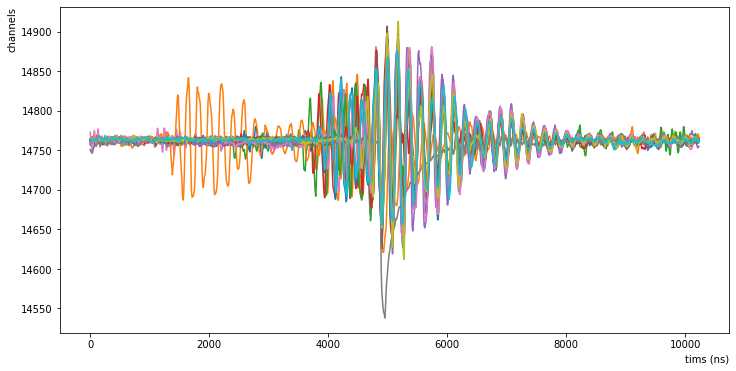

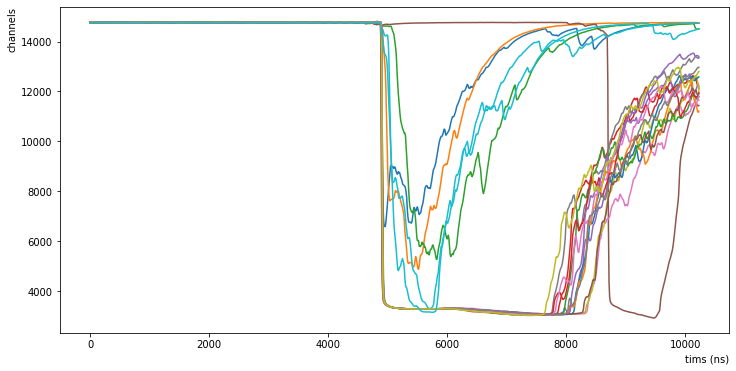

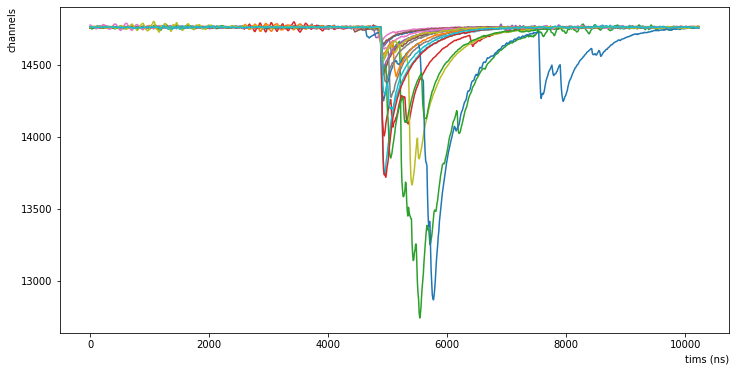

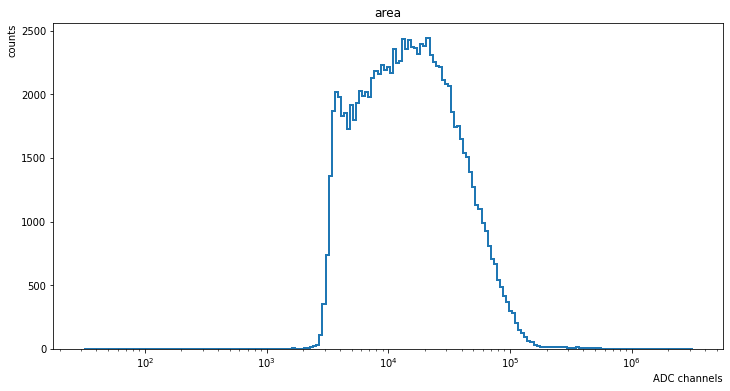

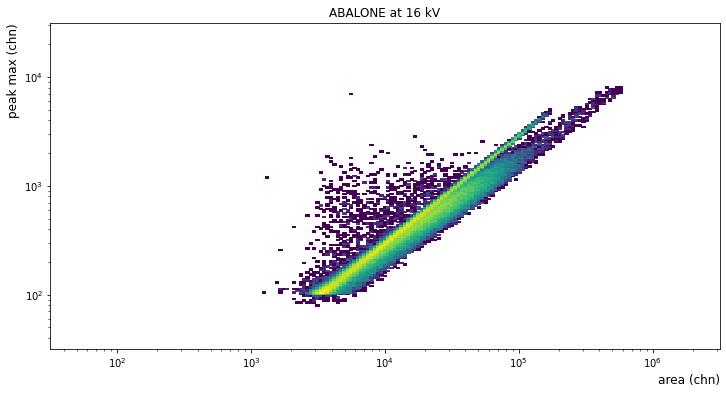

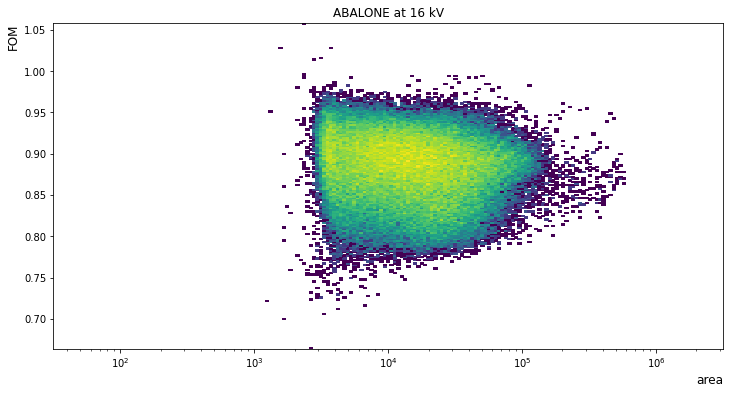

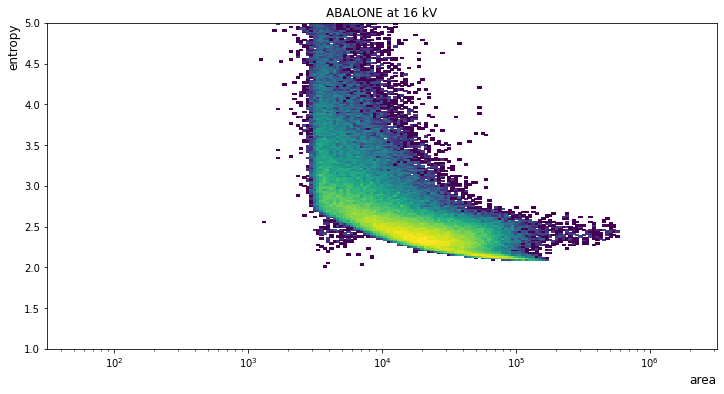

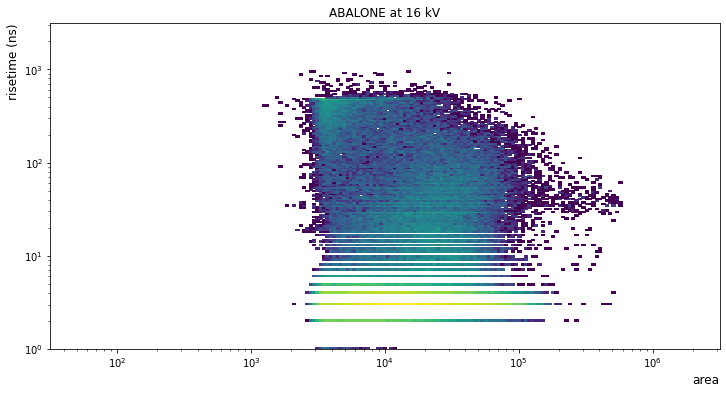

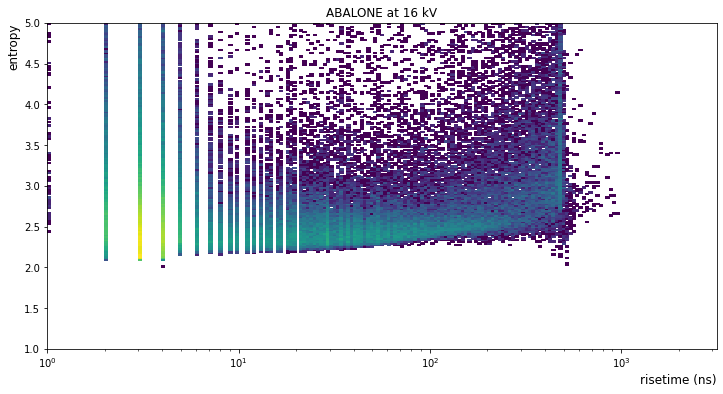

In [46]:
select_data(data,filename='/home/valerio/Scaricati/2021_07_19_T0940_18kV_100threshold.dat',fvolt=18,entr_cut=5,max_cut=8e3,events=20)

In [37]:
fileLED = '/home/valerio/Scaricati/2021_07_19_T1020_18kV_100threshold_LED.dat'

/home/valerio/Scaricati/2021_07_19_T1020_18kV_100threshold_LED.dat Number of events 595358.0
event n. 0 time to process: 0.00
event n. 50000 time to process: 6.01
event n. 100000 time to process: 12.63
event n. 150000 time to process: 19.31
event n. 200000 time to process: 25.37
event n. 250000 time to process: 31.19
event n. 300000 time to process: 37.09
event n. 350000 time to process: 42.98
event n. 400000 time to process: 48.86
event n. 450000 time to process: 54.73
event n. 500000 time to process: 60.95
event n. 550000 time to process: 67.25


/home/valerio/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block2_values] [items->Index(['width'], dtype='object')]

  encoding=encoding,


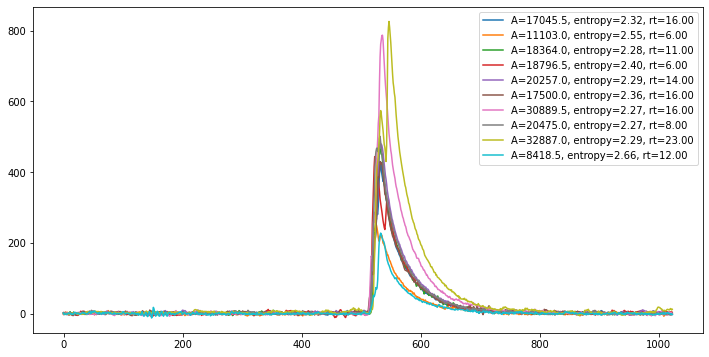

In [29]:
dataLED = process_abalone_data(filename=fileLED,nn=0,nplot=10)

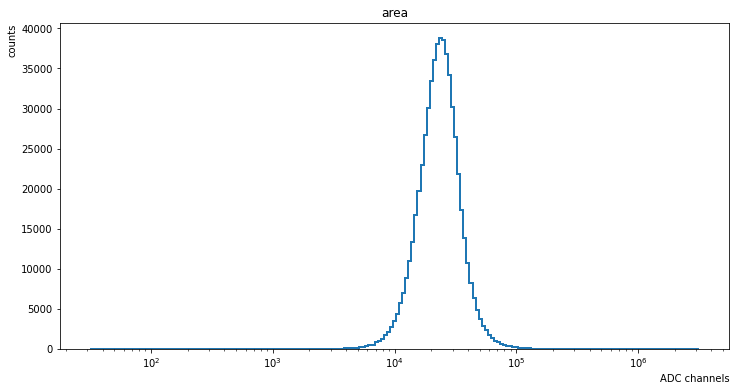

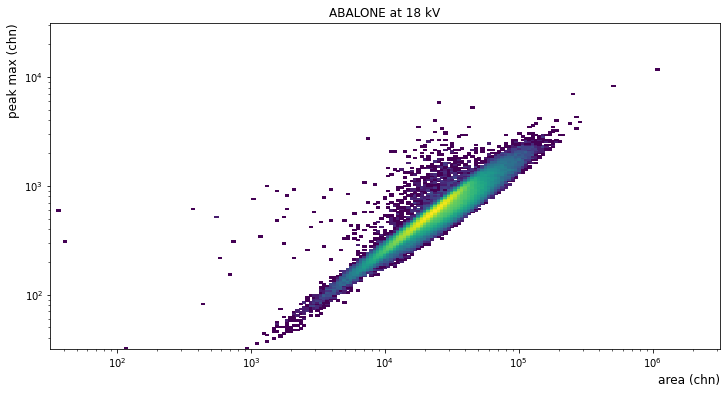

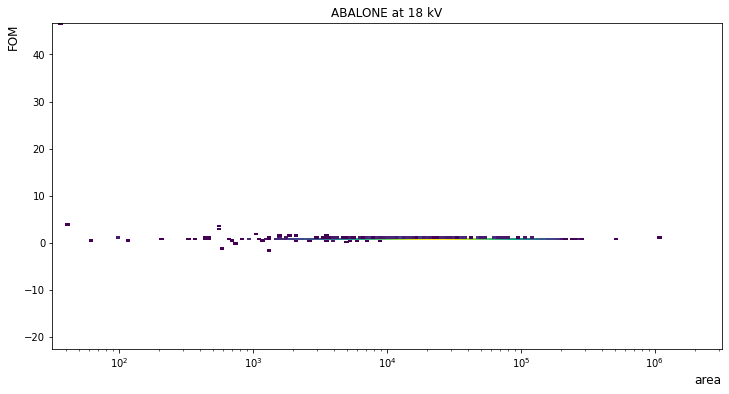

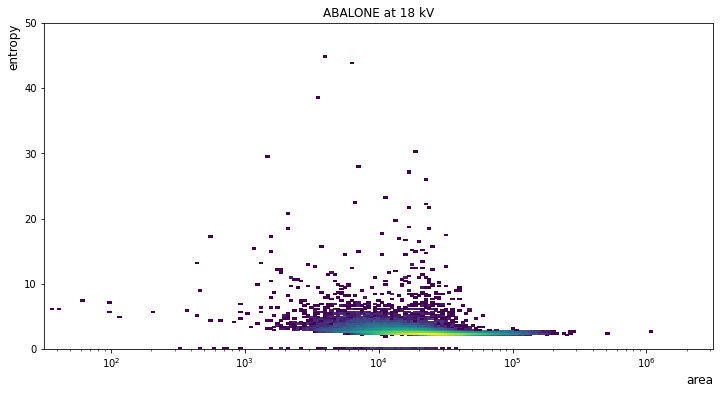

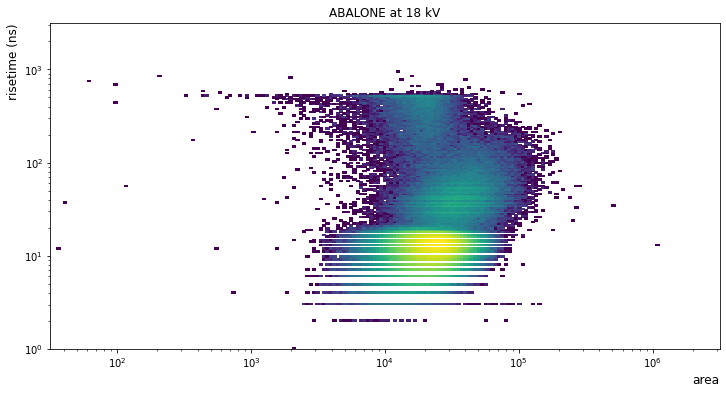

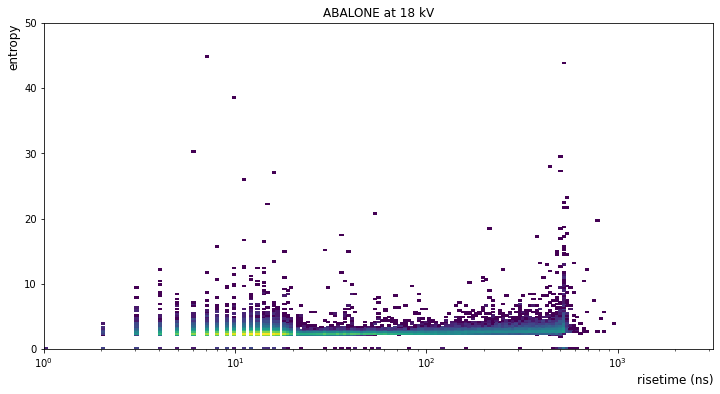

In [39]:
plot_data(data=dataLED,fvolt=18,low=1.5, high=6.5,low3=0, high3=50)

/home/valerio/Scaricati/2021_07_19_T1020_18kV_100threshold_LED.dat Number of events 595358.0
Events rejected by entropy  561 -> 0.09422901850651205 %
Events rejected by max  2 -> 0.0003359323297914868 %
Events selected  594585 -> 99.87016215453559 %


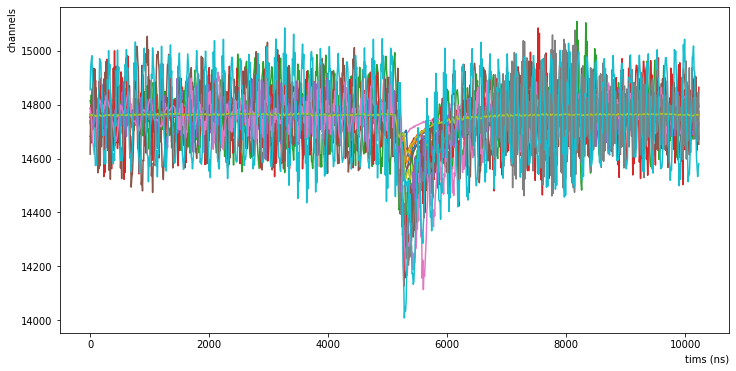

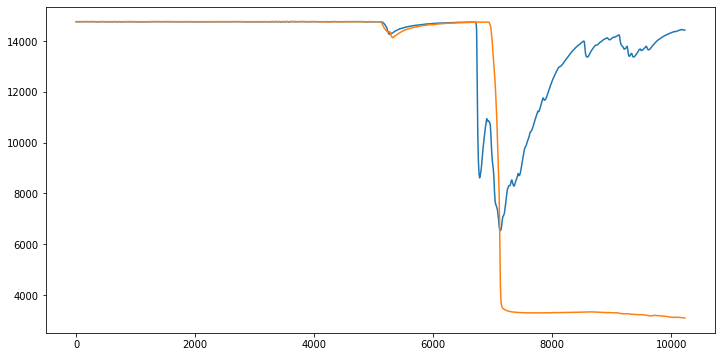

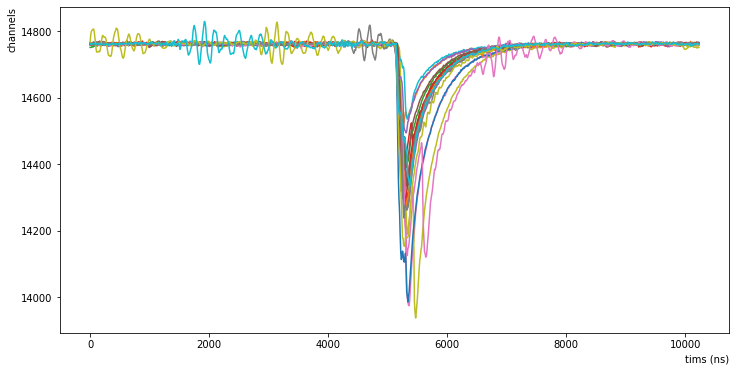

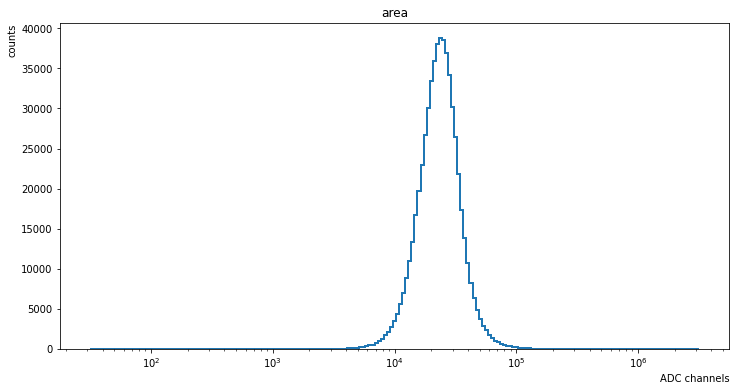

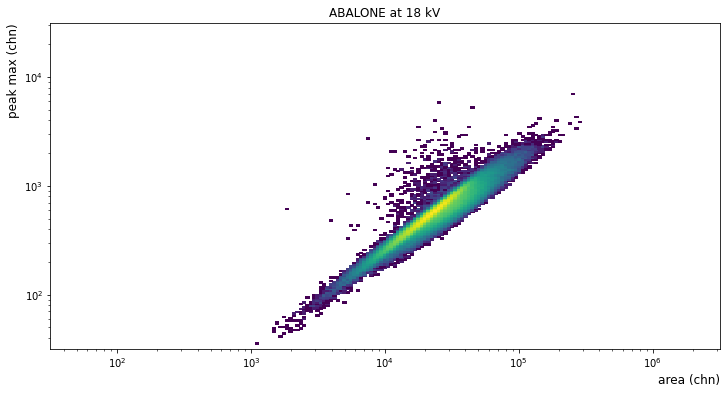

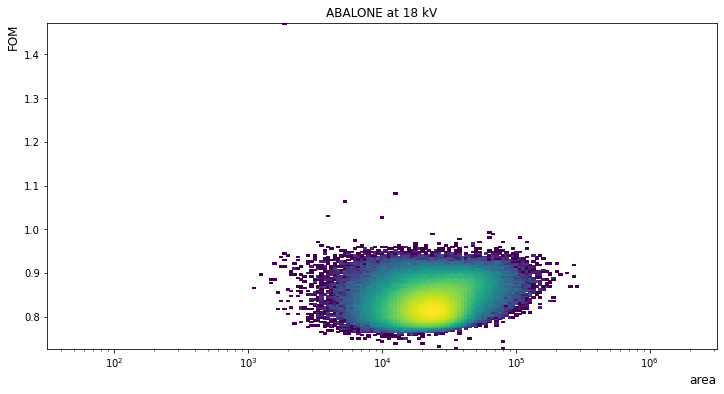

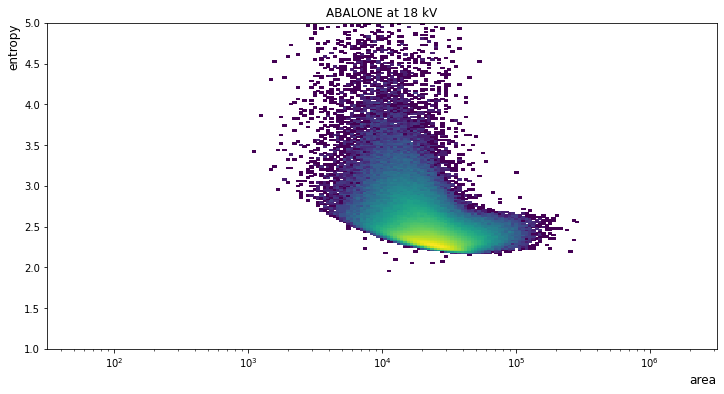

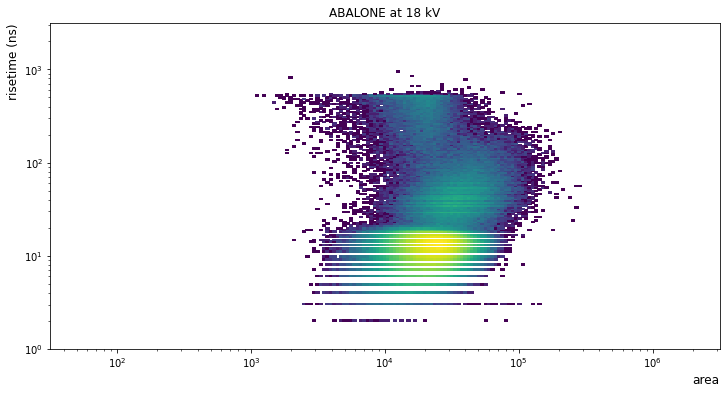

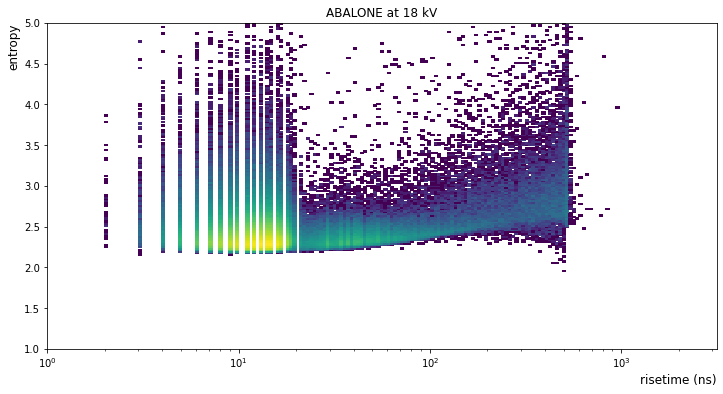

In [49]:
select_data(dataLED,filename=fileLED,fvolt=18,entr_cut=5,max_cut=8e3,events=20)

/home/valerio/Scaricati/2021_07_20_T1622_ABALONE_19kV_SiPM2_30V_LED299V.dat Number of events 592420.0
event n. 0 time to process: 0.05
event n. 50000 time to process: 4.94
event n. 100000 time to process: 9.82
event n. 150000 time to process: 14.64
event n. 200000 time to process: 19.48
event n. 250000 time to process: 24.28
event n. 300000 time to process: 29.10
event n. 350000 time to process: 33.92
event n. 400000 time to process: 38.81
event n. 450000 time to process: 43.74
event n. 500000 time to process: 48.62
event n. 550000 time to process: 53.88


/home/valerio/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block2_values] [items->Index(['width'], dtype='object')]

  encoding=encoding,


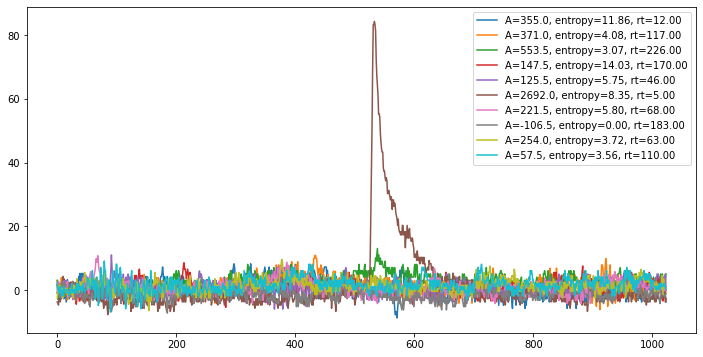

In [8]:
file_LED299 = '/home/valerio/Scaricati/2021_07_20_T1622_ABALONE_19kV_SiPM2_30V_LED299V.dat'
dataLED = process_abalone_data(filename=file_LED299,nn=0,nplot=10)

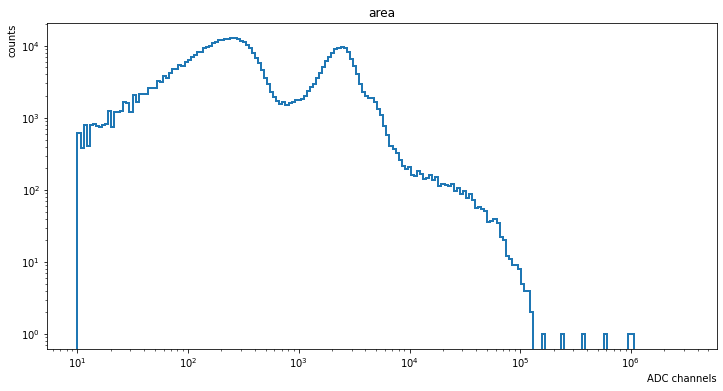

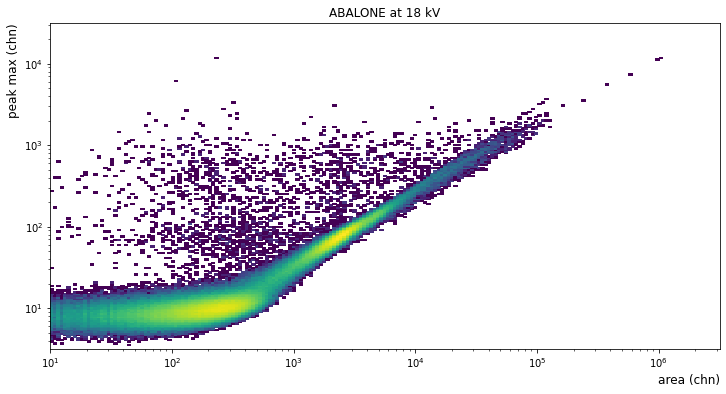

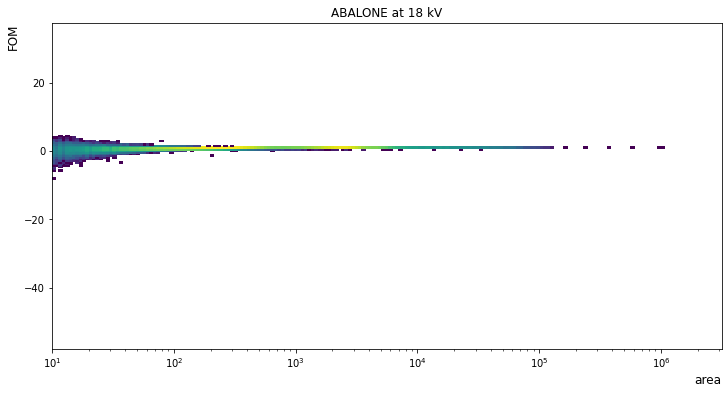

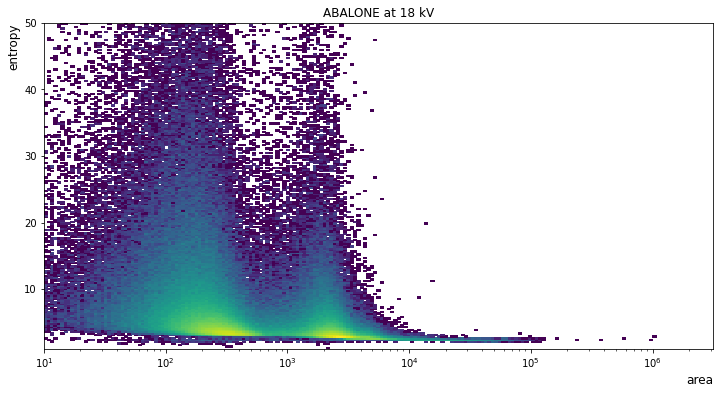

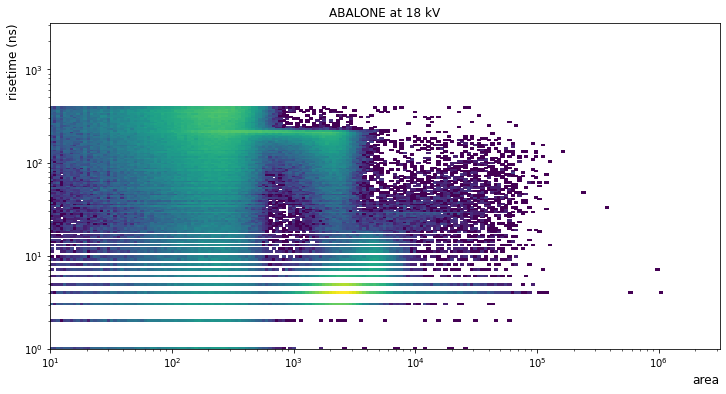

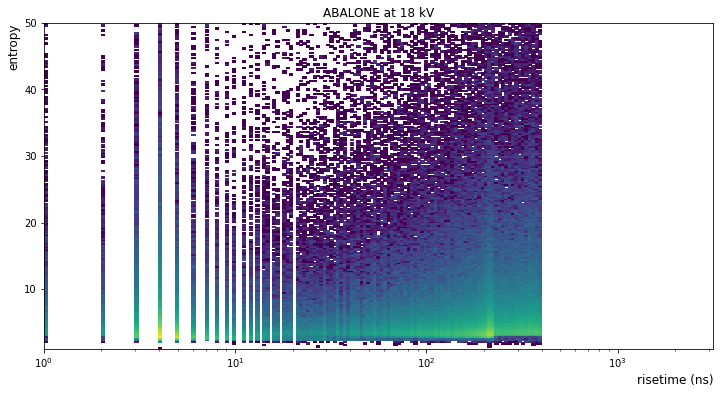

In [9]:
plot_data(data=dataLED,fvolt=18,low=1., high=6.5,low3=1, high3=50)

/home/valerio/Scaricati/2021_07_20_T1622_ABALONE_19kV_SiPM2_30V_LED299V.dat Number of events 592420.0
Events rejected by area  112140 -> 18.929138111474966 %
Events rejected by entropy  8734 -> 1.474291887512238 %
Events rejected by max  448340 -> 75.67941663009351 %
Events rejected by risetime  9199 -> 1.5527834981938489 %
Events selected  133044 -> 22.457715809729585 %


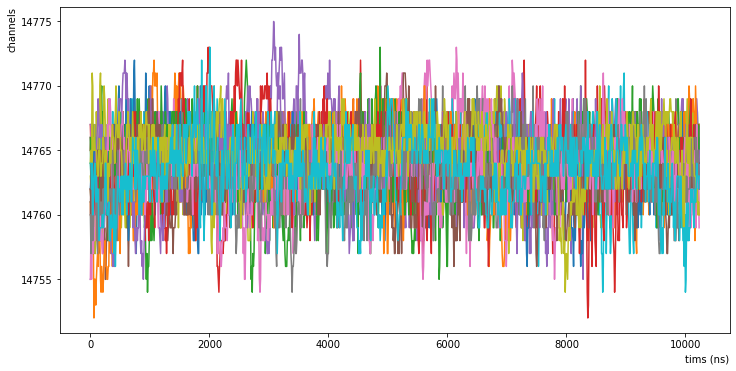

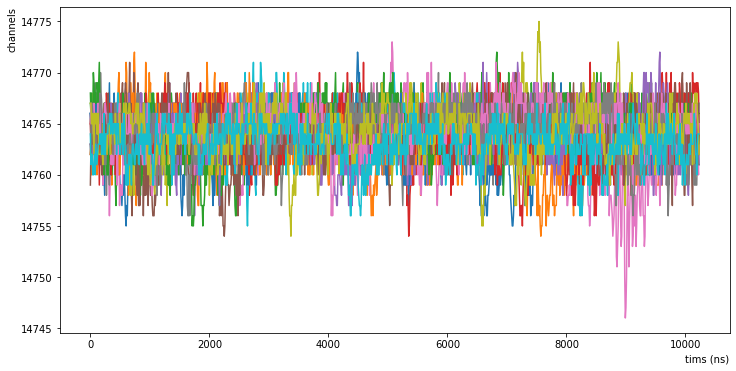

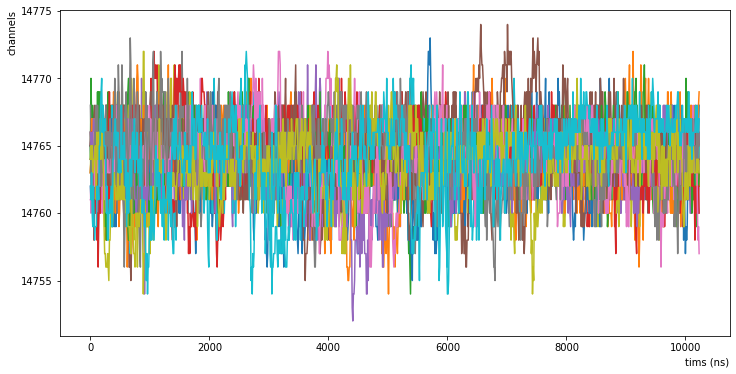

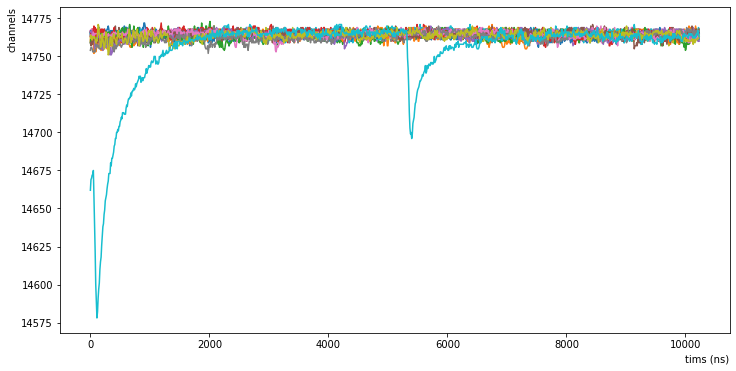

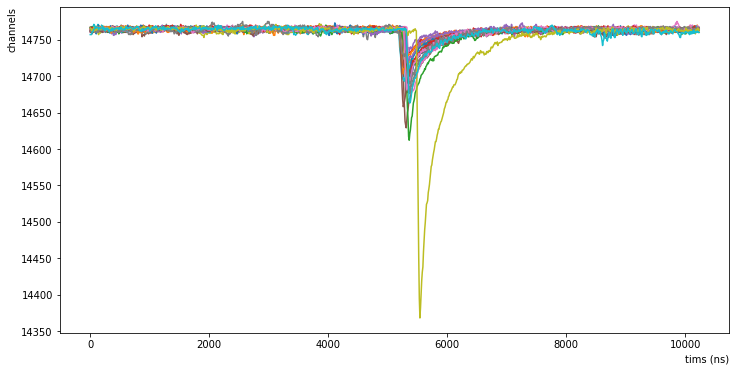

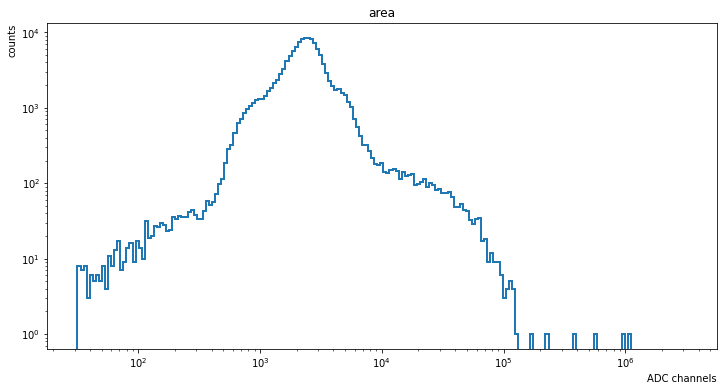

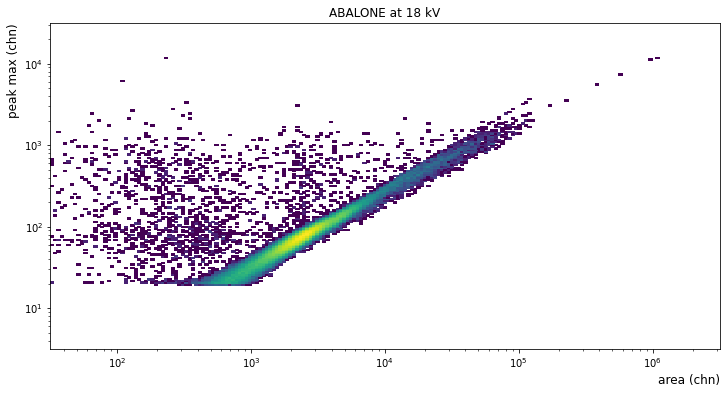

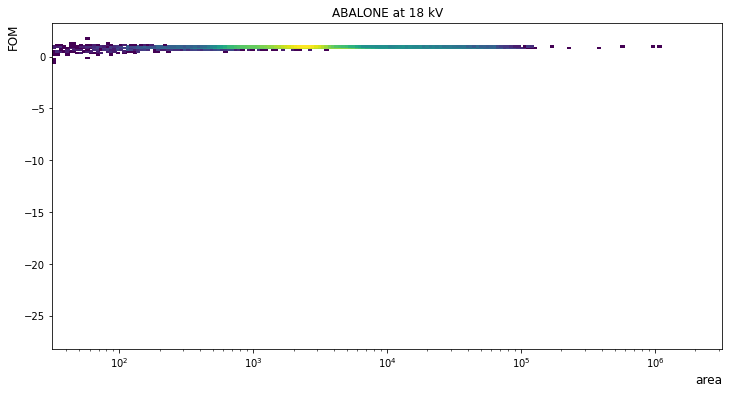

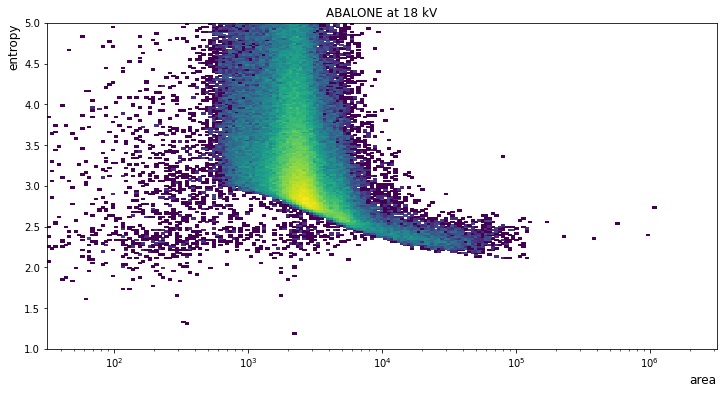

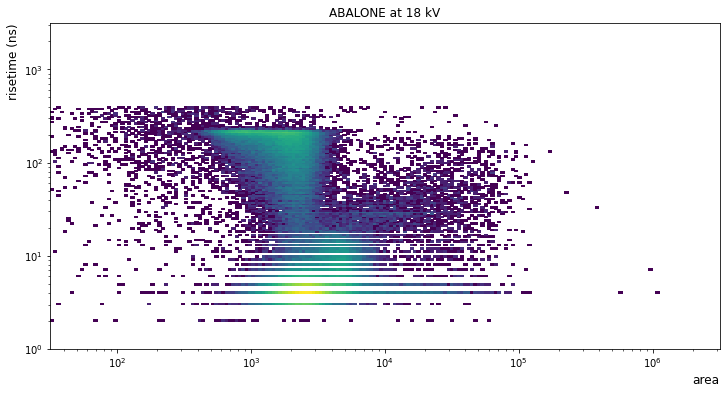

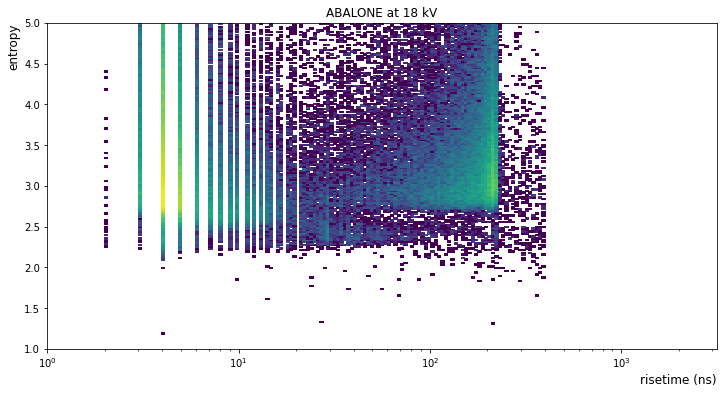

In [13]:
new_data, new_wf = select_data(dataLED,filename=file_LED299,fvolt=18,entr_cut=40,max_cut=20,area_cut=1,rt_cut=1,events=20)

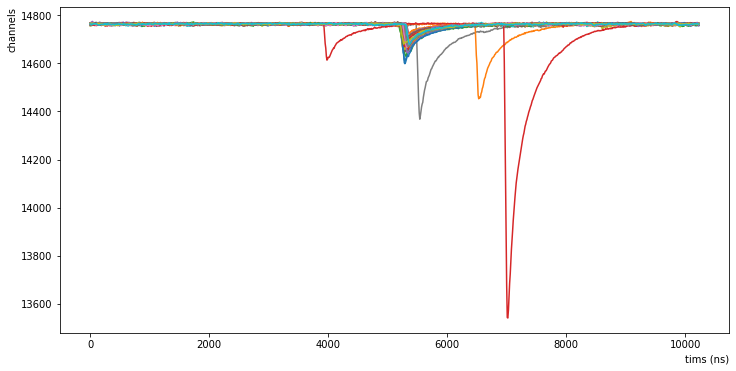

In [24]:
psu.plot_waveforms( new_wf[new_data['risetime']<6], events = 50 )